# Preprocessing of tracer data
    - Needs binned WOD tracer data
    - Needs to enter a 6 digit input parameter as follows : 
    - First digit = Algorithm type (1=RF, 2=NN)
    - Second digit = Data Source (1=Ship only, 2=Ship+Argo)
    - Third digit = Ocean basin (1=Atlantic, 2=Pacific, 3=Indian, 4=Southern, 5=Arctic)
    - Fourth digit = T/S data source (1=EN4, 2=ORAS4)
    - Fifth digit = predictor variable set (1=default, 2=cos/sin_month)
    - Sixth digit = hyperparameter set (1=default, 2=preset hyperparameters)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# version information
ver = '1.2.1.1.2.4'
# The version information will determine which basin / algorithm will be used to calculate the O2 maps. 
o2_cutoff = 600 # this is an arbitrary defined cut-off value to remove very large O2 input data from Argo
endyear = 2021
# define the name of tracer as it is saved in the binned data
var=['Nitrate','TSN2']
eqave=0 # switch to average Bottle and Argo with equal weights regardless of profile counts

### display selection

In [3]:
selection = ver.split('.')
basin = ['Atlantic','Pacific','Indian','Southern','Arctic']
#
if selection[0] == '1':
    print('Random Forst algorithm will be used.')
    alg = 'RF'
elif selection[0] == '2':
    print('Neural Network algorithm will be used.')
    alg = 'NN'
else:
    print('error - incorrect algorithm type')
#
if selection[1] == '1':
    print('Ship-based O2 data will be used. ')
elif selection[1] == '2':
    print('Ship-based and Argo-O2 data will be used. ')
else:
    print('error - incorrect input data type')
#
if selection[2] == '1':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
elif selection[2] == '2':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
elif selection[2] == '3':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
elif selection[2] == '4':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
elif selection[2] == '5':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
else:
    print('error - incorrect O2 data type')
#
if selection[3] == '1':
    print('EN4 dataset will be used for T/S input. ')
elif selection[3] == '2':
    print('ORAS4 dataset will be used for T/S input. ')
elif selection[3] == '3':
    print('SODA3.4.2 dataset will be used for T/S input. ')
else:
    print('error - incorrect T/S data type')
#
if selection[4] == '1':
    print('Predictor variables include T, S, lon, lat, depth (pressure), year, month')
elif selection[4] == '2':
    print('Predictor variables include T, S, lon, lat, depth (pressure), year, cos(month), sin(month)')
elif selection[4] == '3':
    print('Predictor variables include T, S, lon, lat, depth (pressure), year, cos(month), sin(month), sigma0')
elif selection[4] == '4':
    print('Predictor variables include T, S, lon, lat, depth (pressure), year, cos(month), sin(month), sigma0, N2')
else:
    print('error - incorrect predictor variable type')
#
if selection[5] == '1':
    print('Hyperparameter set is optimized via K-fold CV')
elif selection[5] == '2':
    print('A pre-set hyperparameter set is used')
elif selection[5] == '4':
    print('New train/test splid and K-fold cross validation')
else:
    print('error - incorrect hyperparameter type')

Random Forst algorithm will be used.
Ship-based and Argo-O2 data will be used. 
Atlantic Ocean will be mapped
EN4 dataset will be used for T/S input. 
Predictor variables include T, S, lon, lat, depth (pressure), year, cos(month), sin(month)
New train/test splid and K-fold cross validation


In [4]:
# Define the input and output folders
#
os.system('echo $USER > userid')
usrid=np.genfromtxt('userid',dtype='<U16')
os.system('rm userid')
diro = '/glade/derecho/scratch/'+str(usrid)+'/WOD18_OSDCTD/'
dirn =f'/glade/derecho/scratch/{usrid}/ML4O2/inputdata/'
if selection[3]=='1':
    dirf = '/glade/campaign/univ/ugit0034/EN4/L09_20x180x360/'
    dbase='EN4_TSN2_L09_180x360_'
    roll180=0
elif selection[3]=='2':
    dirf = '/glade/campaign/univ/ugit0034/ORAS4/TSN2/'
    dbase='ORAS4_TSN2_'
    roll180=1
#
dirin = './'
fosd='_1x1bin_osd_'
fctd='_1x1bin_ctd_'
fpfl='_1x1bin_pfl_'
#
os.system('mkdir -p '+diro)
os.system('mkdir -p '+dirn)
os.system('mkdir -p '+diro+'temp')

0

### Preprocessing the data

In [5]:
# obtain vertical grid
ds=xr.open_dataset(dirin+var[0]+fosd+'1965-2024'+'.nc')
Z=ds.depth.to_numpy()
Nz=np.size(Z)

In [6]:
# select analysis period
# do not change the start year from 1965 (this is when Carpenter 1965 established modern Winkler method)
yrs=np.arange(1965,endyear,1)
yrs

array([1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020])

Atlantic Ocean will be mapped


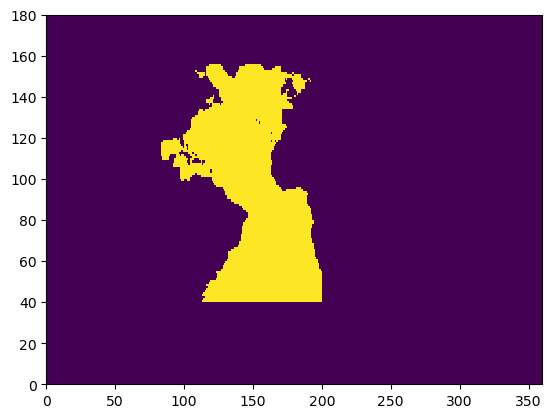

In [7]:
# basin mask
dsm=xr.open_dataset('/glade/campaign/univ/ugit0034/wod18/basin_mask_01.nc')
ma = dsm.basin_mask.isel(depth=0).to_numpy()
#
if selection[2] == '1':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    mask = np.where(ma==1,1,0)
elif selection[2] == '2':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    mask = np.where(ma==2,1,0)
elif selection[2] == '3':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    mask = np.where((ma==3)|(ma==56),1,0)
elif selection[2] == '4':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    mask = np.where(ma==10,1,0)
elif selection[2] == '5':
    print(basin[int(selection[2])-1]+' Ocean will be mapped')
    mask = np.where(ma==11,1,0)
else:
    print('error - incorrect O2 data type')
#
plt.pcolormesh(mask)

In [8]:
#=xr.open_dataset(fargo)
dbot=xr.open_dataset(dirin+var[0]+'_1x1bin_osd_'+'1965-2024'+'.nc')
dargo=xr.open_dataset(dirin+var[0]+'_1x1bin_pfl_'+'1965-2024'+'.nc')
dbot

<xarray.Dataset>
Dimensions:        (time: 720, depth: 47, lat: 180, lon: 360)
Coordinates:
  * time           (time) datetime64[ns] 1965-01-01 1965-02-01 ... 2024-12-01
  * depth          (depth) float64 0.0 5.0 10.0 15.0 ... 850.0 900.0 950.0 1e+03
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon            (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    Nitrate        (time, depth, lat, lon) float64 ...
    sample_count   (time, depth, lat, lon) int64 ...
    profile_count  (time, lat, lon) int64 ...

In [9]:
# Obtain the target variable from observational dataset
#
Nyr=np.size(yrs)
Nt=Nyr*12
mon=["%.2d" % i for i in np.arange(1,13,1)]
#
# 'o2' is used as a placeholder for the target variable
o2=np.zeros((Nt,Nz,180,360))
#
ds1=xr.open_dataset(var[0]+fosd+'1965-2024.nc')
#ds2=xr.open_dataset(var[0]+fctd+'1965-2024.nc')
ds2=xr.open_dataset(var[0]+fpfl+'1965-2024.nc')
#
for year in yrs:
    ytmp=year%10
    if ytmp==0:
        print(str(year))
    tr=12*(year-1965)
    timeind0=(year-2005)*12
    if (year<2007)|(selection[1]=='1'):
        o2[tr:(tr+12),:,:,:]=ds1[var[0]].sel(time=slice(f'{year}-01',f'{year}-12')).to_numpy()
    elif (year<2005)|(selection[1]=='2'):
        o2b = ds1[var[0]].sel(time=slice(f'{year}-01',f'{year}-12')).to_numpy()
        cntb= ds1.sample_count.sel(time=slice(f'{year}-01',f'{year}-12')).to_numpy()
        o2c = ds2[var[0]].sel(time=slice(f'{year}-01',f'{year}-12')).to_numpy()
        cntc= ds2.sample_count.sel(time=slice(f'{year}-01',f'{year}-12')).to_numpy()
        o2b=np.where(np.isnan(o2b),0,o2b)
        o2c=np.where(np.isnan(o2c),0,o2c)
        if eqave == 1:
            cntb[cntb>1]=1 # equal weights
            cntc[cntc>1]=1
        o2[tr:(tr+12),:,:,:]=(o2b*cntb+o2c*cntc)/(cntb+cntc)

1970
1980
1990
2000
2010
2020


In [10]:
#
# Obtain T/S data from observational gridded dataset
#
t=np.zeros((Nt,Nz,180,360))
s=np.zeros((Nt,Nz,180,360))
#sg=np.zeros((Nt,Nz,180,360))
#n2=np.zeros((Nt,Nz,180,360))
#
for year in yrs:
    ytmp=year%10
    if ytmp==0:
        print(str(year))
    tr=12*(year-1965)
    for mn in range(12):
        ds = xr.open_dataset(dirf+dbase+str(year)+mon[mn]+'.nc')
        #print(dirf+dbase+str(year)+mon[mn]+'.nc')
        if roll180==1:
            ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
            ds = ds.sortby(ds.lon)
        s[tr+mn,:,:,:]=ds.SA.interp(depth=Z).to_numpy().squeeze()
        t[tr+mn,:,:,:]=ds.CT.interp(depth=Z).to_numpy().squeeze()
        #sg[tr+mn,:,:,:]=ds.sigma0.interp(depth=Z).to_numpy().squeeze()
        #n2[tr+mn,:,:,:]=ds.N2.interp(depth=Z).to_numpy().squeeze()

1970
1980
1990
2000
2010
2020


In [11]:
# get coordinates
x=ds.lon.to_numpy() 
# use alternative x coordinate: longitude - 20
xa0 = x - 20
xalt = np.where(xa0<0,xa0+360,xa0)
#
y=ds.lat.to_numpy()
xi=np.arange(0,360,1)
yi=np.arange(0,180,1)
xx,yy=np.meshgrid(xalt,y)
xxi,yyi=np.meshgrid(xi,yi)

In [12]:
# extract mask in the Atlantic basin
mask= dsm.basin_mask.sel(depth=Z)

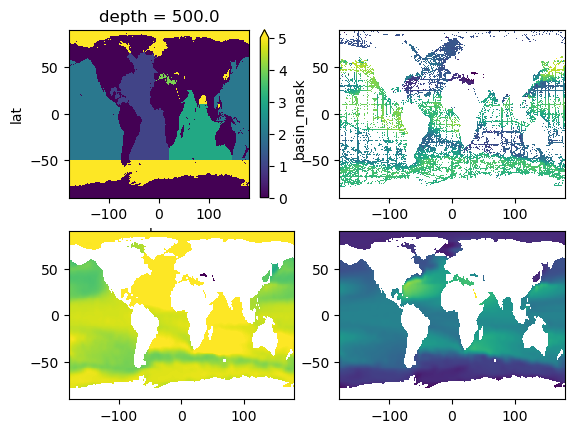

In [13]:
# take a look at the data
fig,ax=plt.subplots(2,2)
# select 500m for plotting
kind=[idx for idx,elem in enumerate(Z) if elem==500]
#
mask.isel(depth=kind).plot(ax=ax[0,0],vmin=0,vmax=5,label='basin_mask')
ax[0,1].pcolormesh(x,y,np.nanmean(o2[:,kind[0],:,:],axis=0))
ax[1,0].pcolormesh(x,y,np.nanmean(s[:,kind[0],:,:],axis=0),vmin=32,vmax=35)
ax[1,1].pcolormesh(x,y,np.nanmean(t[:,kind[0],:,:],axis=0))

In [14]:
# prepare depth lat lon time data
xx1  = np.tile(xx,[Nz,1,1])
yy1  = np.tile(yy,[Nz,1,1])
xxSO = (yy+90)*np.cos(np.deg2rad(xx))
yySO = (yy+90)*np.sin(np.deg2rad(xx))
xxAO = (-yy+90)*np.cos(np.deg2rad(xx))
yyAO = (-yy+90)*np.sin(np.deg2rad(xx))
#
xx1SO = np.tile(xxSO,[Nz,1,1])
yy1SO = np.tile(yySO,[Nz,1,1])
xx1AO = np.tile(xxAO,[Nz,1,1])
yy1AO = np.tile(yyAO,[Nz,1,1])
ztmp  = np.tile(Z,[180,360,1])
zz1   = np.transpose(ztmp,[2,0,1])

In [15]:
dsg=xr.open_dataset('/glade/campaign/univ/ugit0034/ERSST/NOAA_Global_SST.nc')
GMT=dsg.SST.sel(time=slice('1965-01','2020-12')).to_numpy()
print(Nt,GMT.size)

672 672


In [17]:
#Nlev=63
Nlev=47
bnames=['atlantic','pacific','indian','southern','arctic']
bindex=[1,2,3,10,11]
#
for bid in np.arange(1,6,1):
#    sig1=np.array([])
#    nsq1=np.array([])
    dsa1=np.array([])
    dta1=np.array([])
    xx1s=np.array([])
    yy1s=np.array([])
    zz1s=np.array([])
    tt1s=np.array([])
    tc1s=np.array([])
    doa1s=np.array([])
    GMT1=np.array([])
    bname0=bnames[bid-1]
    #
    for n in range(Nt):
        t0 = n
        t1 = t0%12
        tt1 = np.ones((Nz,180,360))*t0
        tc1 = np.ones((Nz,180,360))*t1
        GMT0= np.ones((Nz,180,360))*GMT[n]
        #if t1==0:
        #    print(n/12+1965)
        o20=o2[n,:,:,:]
        theta0=t[n,:,:,:]
        s0=s[n,:,:,:]
        #sig0=sg[n,:,:,:]
        #nsq0=n2[n,:,:,:]
        tmp = o20+theta0+s0#+sig0+nsq0
        #
        #print(bnames[bid-1])
        if bid==3:
            dd = np.where((mask==3)|(mask==56),tmp,np.nan)
        else:
            dd = np.where(mask==bindex[bid-1],tmp,np.nan)
        #
#        sig1=np.concatenate((dsa1,sig0[np.isnan(dd)==False]))
#        nsq1=np.concatenate((dsa1,nsq0[np.isnan(dd)==False]))
        dsa1=np.concatenate((dsa1,s0[np.isnan(dd)==False]))
        dta1=np.concatenate((dta1,theta0[np.isnan(dd)==False]))
        #
        if bid == 4:
            xx1s=np.concatenate((xx1s,xx1SO[np.isnan(dd)==False]))
        elif bid == 5:
            xx1s=np.concatenate((xx1s,xx1AO[np.isnan(dd)==False]))
        else:
            xx1s=np.concatenate((xx1s,xx1[np.isnan(dd)==False]))
        if bid == 4:
            yy1s=np.concatenate((yy1s,yy1SO[np.isnan(dd)==False]))
        elif bid == 5:
            yy1s=np.concatenate((yy1s,yy1AO[np.isnan(dd)==False]))
        else:
            yy1s=np.concatenate((yy1s,yy1[np.isnan(dd)==False]))
        #
        zz1s=np.concatenate((zz1s,zz1[np.isnan(dd)==False]))
        tt1s=np.concatenate((tt1s,tt1[np.isnan(dd)==False]))
        GMT1=np.concatenate((GMT1,GMT0[np.isnan(dd)==False]))
        tc1s=np.concatenate((tc1s,tc1[np.isnan(dd)==False]))
        doa1s=np.concatenate((doa1s,o20[np.isnan(dd)==False]))
        #
    #
    Nsample = np.size(doa1s)
    print(bname0,Nsample)    
    np.save(f'{dirn}{var[0]}0_{bname0}_1x1_{Nlev}lev.npy',doa1s)
    np.save(f'{dirn}month0_{bname0}_1x1_{Nlev}lev.npy',tc1s)
    np.save(f'{dirn}time0_{bname0}_1x1_{Nlev}lev.npy',tt1s)
    np.save(f'{dirn}depth0_{bname0}_1x1_{Nlev}lev.npy',zz1s)
    np.save(f'{dirn}lon0_{bname0}_1x1_{Nlev}lev.npy',xx1s)
    np.save(f'{dirn}lat0_{bname0}_1x1_{Nlev}lev.npy',yy1s)
    np.save(f'{dirn}t0_{bname0}_1x1_{Nlev}lev.npy',dta1)
    np.save(f'{dirn}s0_{bname0}_1x1_{Nlev}lev.npy',dsa1)
#    np.save(f'{dirn}sig0_{bname0}_1x1_{Nlev}lev.npy',sig1)
#    np.save(f'{dirn}nsq0_{bname0}_1x1_{Nlev}lev.npy',nsq1)
    np.save(f'{dirn}GMT0_{bname0}_1x1_{Nlev}lev.npy',GMT1)

atlantic 594798
pacific 1240901
indian 210613
southern 460909
arctic 254484
